In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

# 模型选择、欠拟合和过拟合
将模型在训练数据上拟合的比在潜在分布中更加接近的现象称为**过拟合**(`overfiting`), 用于对抗过拟和的技术称为**正则化** 
## 训练误差与泛化误差
- 训练误差: 模型在训练数据集上计算得到的误差
- 泛化误差: 模型应用在同样从原始样本的分布中抽取的无限多数据样本时, 模型误差的期望
#### 统计学习理论
主要强调了数据的独立同分布特性
#### 模型复杂度
不同的模型之间(比如决策树和神经网络)难以比较复杂度, 对于神经网络而言, 可以认为更多训练迭代的模型比较复杂, 需要早停的模型(较少训练迭代周期)的模型不是那么复杂;

几个可能影响模型繁华的因素如下:
1. 可调整的参数数量, 当可调整参数的数量很大的时候, 模型容易过拟合
2. 参数采用的值, 当权重的取值范围较大的时候, 模型容易过拟合
3. 训练样本的数量, 即使模型很简单, 也容易过拟合一两个样本的数据集, 而过拟和一个有很多样本的数据集需要一个很灵活的模型

## 模型选择
模型选择主要包括两个方面:
1. 选择不同模型: 比如使用决策树还是线性模型等
2. 或者比较不同超参数设置下的同一类模型, 比如多层感知机模型中的学习率的设置, 以及隐藏层数量的设置、隐藏单元数量的设置等

为了确定候选模型中的最佳模型, 通常会使用验证集

### 验证集
原则上, 在确定所有超参数之前, 不应该使用测试集(也就是不能把测试集数据加入到训练集中); 但是在模型训练过程中, 虽然是使用训练集对于模型进行训练, 最后对于测试集进行测试, 但是如果使用固定的测试集, 依然可能导致模型在测试集上的过拟合, 并且这一种过拟合是无从得知的 ;

解决此问题常用的方法是把数据分为三分: 出了训练和测试数据之外, 还需要新增一个验证数据集, 也就是 **验证集**; 但是验证数据和测试数据之间的边界比较模糊, 所以除非另有说明, I**在本书的实验中, 实际上是在使用应该被正确地称为训练数据和验证数据的数据集, 没有真正的测试数据集** , 所以每一次实验的准确度都是验证集准确度, 而不是测试集准确度

### K折交叉验证
当训练的数据稀缺的时候, 可能无法提供足够的数据来构成一个合适大小的验证集, 此时可以使用 **K折交叉验证**, 此时原始数据可以分为 $K$ 个不重叠的子集, 之后执行 $K$次数模型训练和验证, 每一次在 $K - 1$ 个子集熵进行训练, 并且在剩余的一个子集上进行测试, 最后通过 $K$ 次实验的结果取平均值来估计训练和验证误差

## 欠拟合还是过拟合
- 欠拟合: 训练误差和验证误差都比较严重, 如果模型无法降低训练误差, 那么意味着模型可能过于简单, 无法捕获试图学习的模式 ; 另外由于训练和验证误差之间的泛化误差(表示二者的差异不大)比较小, 所以可以认为有一个更加复杂的模型可以降低训练误差, 这一种现象称为 **欠拟合**
- 过拟合: 如果训练误差明显地与验证误差的时候需要注意, 此时模型可能处于**过拟合**

是否过拟合或者欠拟合可能取决于模型复杂度以及可用的训练数据集大小
### 模型复杂度
假设需要建立一个多项式关系的模型, 也就是输出和输入的单个特征存在多项式关系:
$$
\hat{y} = \sum_{i=0}^d x^i{\omega}_i
$$
高阶多项式的模型复杂度始终大于低阶模型的复杂度, 训练损失和泛化损失随着模型复杂度的变换情况可能如下:
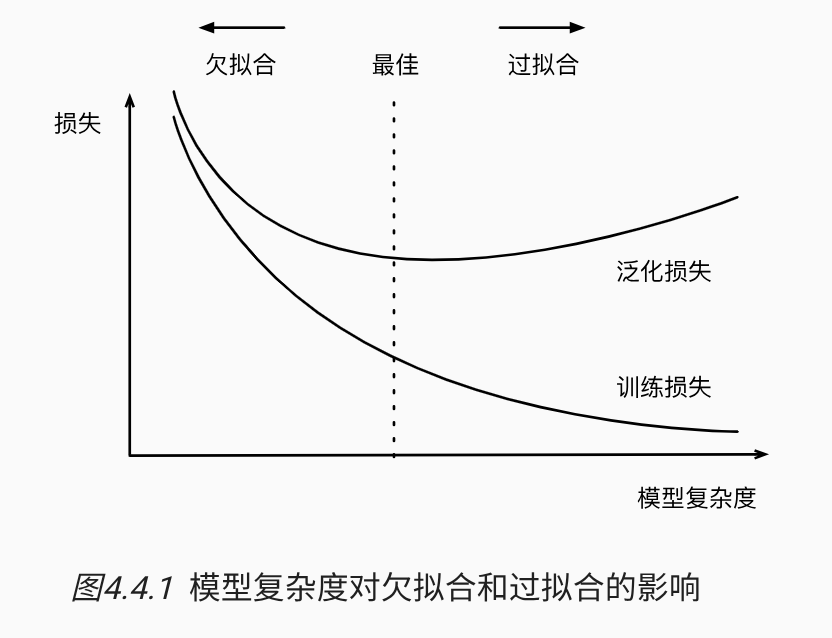

### 数据集大小
影响模型欠拟合或者过拟合的另外一个重要因素是训练集的大小, 训练集中的样本数据越少, 越可能过拟合, 随着训练数据量的增加, 泛化误差通常会减小

## 多项式回归
> 这里使用多项式回归来模拟和探索这些概念

### 生成数据集
下面是用如下的三阶多项式来生成训练和测试数据的标签:
$$
y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6\frac{x^3}{3!} + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, 0.1^2)
$$

In [21]:
# 生成数据集
# 注意输入和输出信息的维度关系等
# features: 特征 [x_1, x_2, x_3, ... , x_n]^T (n*1) 
# poly_features: 多项式中的特征: [x_1^1/1! , x_1^2/2!, ... , x_1^n/n!] 并且进行拓展 (n*20)
# labels = [y_1, y_2, ... y_n]  
# true_w = [w_1, w_2, ..., w_n] # 1*20
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degree) # max_degree * 1 大小, 表示各次项前系数
true_w[0:4] = np.array([5, 1.2, -34, 5.6])

features = np.random.normal(size=(n_train+n_test, 1))  # 训练集和测试集的特征
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) # 特征乘以固定的次数
for i in range(max_degree):
    poly_features[:, i]/=math.gamma(i + 1)  # gamma(n) = (n - 1)!
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1,size=labels.shape) # 加上噪声

In [22]:
# 转换为 tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x
                                          in [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.4100],
         [-1.8172]]),
 tensor([[ 1.0000e+00, -4.0996e-01,  8.4033e-02, -1.1483e-02,  1.1769e-03,
          -9.6498e-05,  6.5934e-06, -3.8614e-07,  1.9788e-08, -9.0136e-10,
           3.6952e-11, -1.3772e-12,  4.7048e-14, -1.4837e-15,  4.3446e-17,
          -1.1874e-18,  3.0424e-20, -7.3369e-22,  1.6710e-23, -3.6055e-25],
         [ 1.0000e+00, -1.8172e+00,  1.6512e+00, -1.0002e+00,  4.5438e-01,
          -1.6514e-01,  5.0017e-02, -1.2985e-02,  2.9495e-03, -5.9554e-04,
           1.0822e-04, -1.7879e-05,  2.7075e-06, -3.7847e-07,  4.9126e-08,
          -5.9515e-09,  6.7595e-10, -7.2256e-11,  7.2948e-12, -6.9769e-13]]),
 tensor([  1.5274, -58.9373]))

### 对模型进行训练和测试

In [23]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [34]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [35]:
# 模型训练, 注意此时需要训练得到的参数是多项式前面的数据
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    # 返回最后一个维度大小
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 三阶多项式函数拟合

weight: [[  4.991453    1.2077992 -33.97646     5.5910816]]


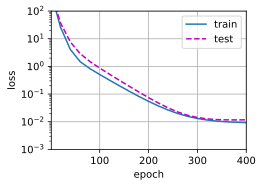

In [36]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 线性函数拟合(欠拟合)

weight: [[-10.950763   5.472892]]


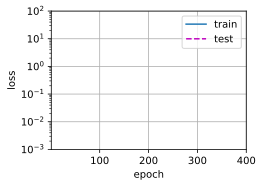

In [39]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 高阶多项式拟合(过拟合)

weight: [[ 4.8958750e+00  1.1825817e+00 -3.3421040e+01  5.4697781e+00
  -1.8220764e+00  1.5674579e+00  7.2259367e-01  2.4669255e-01
   3.0745900e-01  1.1849739e-01  1.2235064e-01 -6.1255906e-02
  -2.1123736e-01 -4.7359660e-02 -4.0574949e-02 -1.9950195e-01
  -2.0984524e-01 -1.5525118e-01  1.3017352e-02 -1.4771931e-01]]


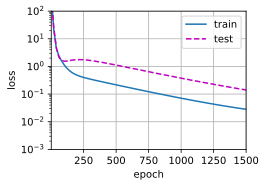

In [41]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

## 总结
- 欠拟合是指模型无法继续减少训练误差。过拟合是指训练误差远小于验证误差。
- 由于不能基于训练误差来估计泛化误差，因此简单地最小化训练误差并不一定意味着泛化误差的减小。机器学习模型需要注意防止过拟合，即防止泛化误差过大。
- 验证集可以用于模型选择，但不能过于随意地使用它。
- 我们应该选择一个复杂度适当的模型，避免使用数量不足的训练样本

特别注意**欠拟合**和**过拟合**的特征
- 欠拟合: 训练误差和测试误差都比较大, 并且之间的泛化误差比较小
- 过拟合: 训练误差比较小, 但是测试误差比较大